In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_patten(season_time):
  """Just an arbitrary patten, you can change it if you wish"""
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2 * np.pi),
                  1/ np.exp(3 * season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  """Repeasts the same patten at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_patten(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time , 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series 

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.04711499],
       [-0.04866884],
       [ 0.0542619 ],
       [ 0.07089318],
       [-0.00117942],
       [ 0.0023417 ],
       [-0.09724849],
       [ 0.07120151],
       [ 0.02100188],
       [-0.04005364],
       [ 0.01409227],
       [-0.00184325],
       [ 0.0022717 ],
       [-0.0008573 ],
       [-0.02668729],
       [ 0.14829366],
       [-0.01429807],
       [ 0.17378703],
       [ 0.23782608],
       [ 0.476248  ]], dtype=float32), array([0.01955731], dtype=float32)]


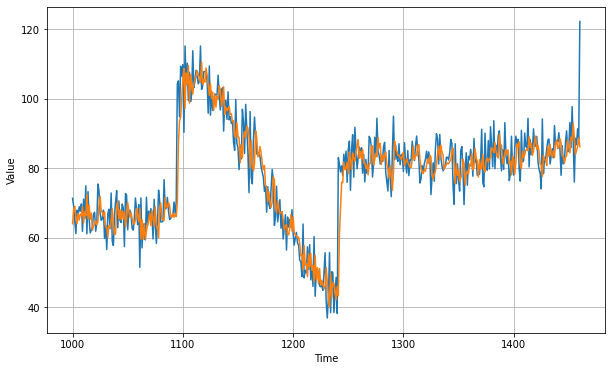

In [9]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9937897

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

model.fit(dataset, epochs=100, verbose=0)

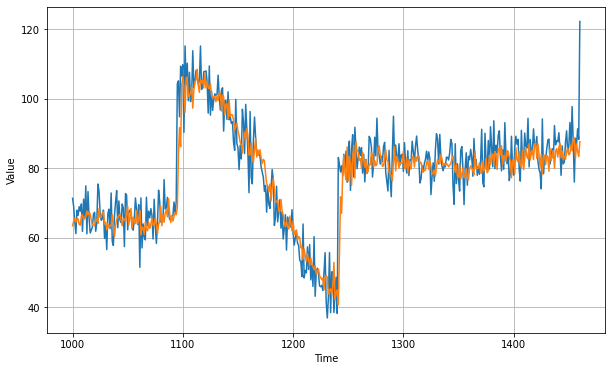

In [12]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.850008

In [19]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

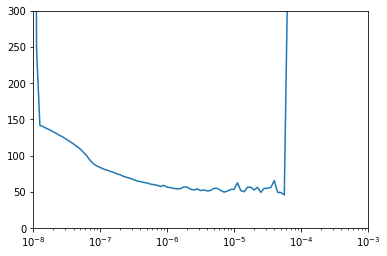

In [20]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [21]:

window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)

history = model.fit(dataset, epochs=500, verbose=0)

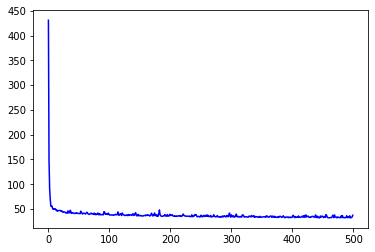

In [23]:
loss = history.history["loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[49.542903900146484, 50.5711669921875, 48.95930099487305, 46.7353630065918, 47.76821517944336, 45.56305694580078, 46.295806884765625, 47.05967330932617, 47.158851623535156, 46.99184799194336, 46.58431625366211, 45.06739807128906, 46.12984848022461, 44.79729461669922, 43.35221862792969, 44.060768127441406, 44.12166976928711, 44.034019470214844, 42.46356201171875, 41.99010467529297, 42.93568420410156, 41.648338317871094, 46.26890182495117, 42.43705368041992, 42.089847564697266, 44.047603607177734, 47.5305290222168, 41.736576080322266, 43.3559455871582, 41.65836715698242, 42.26532745361328, 42.275936126708984, 41.478553771972656, 40.67659378051758, 41.61111831665039, 42.3201789855957, 41.16199493408203, 41.94293212890625, 40.96188735961914, 41.24025344848633, 41.017845153808594, 40.85941696166992, 40.54529571533203, 45.71405792236328, 42.47285842895508, 41.84498596191406, 39.79927062988281, 41.59525680541992, 41.53715133666992, 40.9539794921875, 40.32566833496094, 39.999664306640625, 41.9

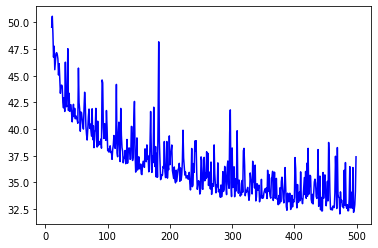

In [24]:
# Plot all but the first 10

loss = history.history['loss']

epochs = range(10, len(loss))

plot_loss = loss[10:]

print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

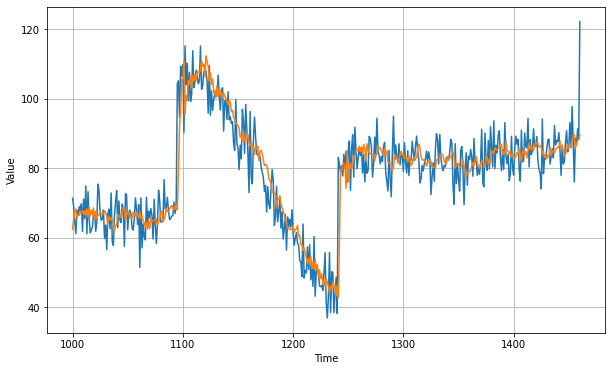

In [25]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8298244